In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#Uses gpu, if thats not possible it makes use of the cpu instead
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Resizes the images to 128x128 pixels, Turns them into a tensor, and normalizes them
tf = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

#Data Loaders(Training Data, Testing Data)
train_dl = DataLoader(
    datasets.ImageFolder('data/Training/',tf),
     batch_size=32, shuffle=True, num_workers=4, pin_memory=True
)

test_dl = DataLoader(
    datasets.ImageFolder('data/Testing/',tf),
    batch_size=32, shuffle=False, num_workers=4, pin_memory=True
)

In [2]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128*16*16, 256), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(256, 4) #4 classes
).to(device)

In [3]:
#defines an Optimizer
opt = optim.AdamW(model.parameters(), 1e-4)
loss_fn = nn.CrossEntropyLoss()

In [4]:
#Training Loop

model.train() #Put model into training mode

#loop thru all the images. 25 times
for epoch in range(25):
    runnig_loss = 0 #keeps track of each loss during an iteration

    for x, y in train_dl: #x->inputs, y->labels
        opt.zero_grad() #clears gradients each iteration so they dont mix old gradients with new ones

        loss = loss_fn(model(x.to(device)), y.to(device)) #moves data to gpu or cpu,  makes a forward pass (model(x)), calculates the loss
        loss.backward() #calculates gradients(how much to change the weigh, up or down a bit)

        runnig_loss += loss #adds current loss to total loss for current epoch too see how bad the model did during that iteration

        opt.step() #updates models internal valus using our updated gradients so it can make fewer mistakes
    print(f'Epoch {epoch+1}: Loss was {runnig_loss}')

C:\Users\Caleb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1: Loss was 151.3242645263672
Epoch 2: Loss was 104.49671173095703
Epoch 3: Loss was 87.087646484375
Epoch 4: Loss was 76.48216247558594
Epoch 5: Loss was 68.03810119628906
Epoch 6: Loss was 61.05775451660156
Epoch 7: Loss was 55.14859390258789
Epoch 8: Loss was 49.41773986816406
Epoch 9: Loss was 44.211158752441406
Epoch 10: Loss was 40.97890090942383
Epoch 11: Loss was 37.097599029541016
Epoch 12: Loss was 33.03163146972656
Epoch 13: Loss was 30.96462631225586
Epoch 14: Loss was 27.512710571289062
Epoch 15: Loss was 24.59536361694336
Epoch 16: Loss was 22.974102020263672
Epoch 17: Loss was 19.861217498779297
Epoch 18: Loss was 18.64061164855957
Epoch 19: Loss was 16.552656173706055
Epoch 20: Loss was 16.527938842773438
Epoch 21: Loss was 14.545331001281738
Epoch 22: Loss was 12.625187873840332
Epoch 23: Loss was 12.37467098236084
Epoch 24: Loss was 12.473794937133789
Epoch 25: Loss was 10.659469604492188


In [5]:
#Evaluation Loop


model.eval() #Turns off training only behaviours


test_loss, correct = 0.0, 0 #keeps track of total incorrrect, and correct predictions

with torch.no_grad(): #Restricts the use of gradients, doesnt store info needed for backpropagation
    for x,y in test_dl: #loops thru test dataloader, and gives model data in batches
        x,y = x.to(device), y.to(device) #puts batchs into gpu or cpu depending on avaliblity

        logits = model(x) #does a forward pass (asks model fo its preditions)
        test_loss += loss_fn(logits,y).item() * y.size(0) #takes the loss of the patch multiplys it by the size of the batch to get the average loss of the batch and adds it to the total loss

        preds = logits.argmax(dim=1) #for each row in the batch it picks the index of the highest number (highest number = models prediction)
        correct += (preds == y).sum().item() #counts how much of the predcition were right 

test_loss /= len(test_dl.dataset) #takes the total loss and divdes it by the number of test sample to get the average loss per test
accuracy = 100.0 * correct/len(test_dl.dataset) #takes the total corect devided by the test sample and multiple by 100 to get the accuracy percentage

print('Test Loss:', test_loss, 'Test Accuracy', accuracy,'%') #prints total loss and accruacu

Test Loss: 0.14423815883093313 Test Accuracy 96.03356216628528 %


Predicted Class: notumor
Ground Truth: notumor 


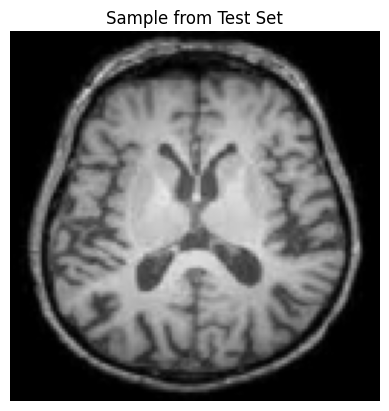

In [7]:
import random

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

model.eval() #puts model in evaluation mode

indx = random.randrange(len(test_dl.dataset)) #picks a random number from 0 to the length of the test data set
img, label = test_dl.dataset[indx] #variables to store the image at the index found above, and its label

unnormalize = img * 0.5 + 0.5 #unnormalizes the image so it can be seen by humans (when normliazed the images pixel values are changed ot -1 and 1, but images cant be shown proberly in that range, so you cahnge the pixel values back to 0 and 1)
plt.imshow(to_pil_image(unnormalize)) #Converts pyTorch tensor to normal image and displays it
plt.axis('off') #hides x and y grid lines
plt.title('Sample from Test Set') #Give image a title

with torch.no_grad(): #Tells model to not track graidents as we are not training anymore(waste of memory)
    logits = model(img.unsqueeze(0).to(device)) #model does its evaltion on img and gets its raw scores for each class (how likley each type is to be true) (unsqueeze adds a new dimension so that it can be accepted [3,32,32] -> [1,3,32,32], creates a batch of size 1) 
    pred = logits.argmax(1).item() #gets the index of the models largest score(which is its prediction)

class_names = test_dl.dataset.classes #list of the class_names [the 4 brain tumor types]
print(f"Predicted Class: {class_names[pred]}") #Gets the name of the predicted brain tumor 
print(f"Ground Truth: {class_names[label]} ") #Gets the real name of the brain tumor
